In [1]:
!pip install gdown
!gdown --id 1xOVIFNuVCtckeD725TBZKhY1pZNtfaFT

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1xOVIFNuVCtckeD725TBZKhY1pZNtfaFT
From (redirected): https://drive.google.com/uc?id=1xOVIFNuVCtckeD725TBZKhY1pZNtfaFT&confirm=t&uuid=7f7731c4-024b-4925-a89b-83f7e2e8e0a5
To: /kaggle/working/ISIC-images-160.zip
100%|██████████████████████████████████████| 95.9M/95.9M [00:03<00:00, 29.6MB/s]


In [2]:
import zipfile, os

currentDirectory = '/kaggle/working/'
zipFileName = "/kaggle/working/ISIC-images-160.zip"
with zipfile.ZipFile(zipFileName, 'r') as zip_ref:
    zip_ref.extractall(currentDirectory)

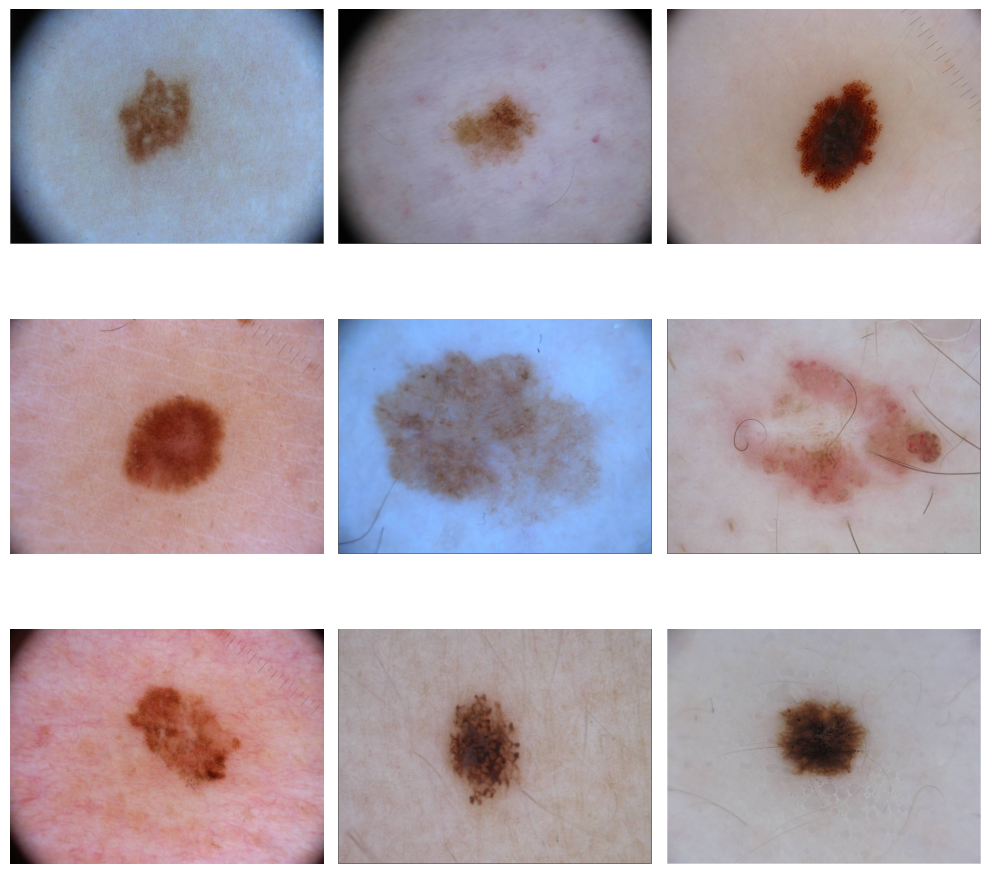

In [3]:
import matplotlib.pyplot as plt

directory = '/kaggle/working/ISIC-images/UDA-1'
imageFiles = [file for file in os.listdir(directory) if file.endswith('.jpg') or file.endswith('.png')]
numImages = min(len(imageFiles), 9)
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i in range(numImages):
    img = plt.imread(os.path.join(directory, imageFiles[i]))
    axes[i // 3, i % 3].imshow(img)
    axes[i // 3, i % 3].axis('off')
plt.tight_layout()
plt.show()

In [4]:
import numpy as np
import shutil

import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torchvision.utils as vutils
from torchvision.utils import save_image
import torch.optim as optim

In [5]:
imagesPath='/kaggle/working/ISIC-images'
imageSize=128
batchSize=16
workersNum=2

In [6]:
def dataLoader(path, image_size, batch_size, workers):
    dataset = dset.ImageFolder(root=path,
                               transform=transforms.Compose([
                                   transforms.Resize(image_size),
                                   transforms.CenterCrop(image_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ]))
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=workers)

    return dataloader

In [7]:
dataloader = dataLoader(
            path=imagesPath, 
            image_size=imageSize,
            batch_size=batchSize,
            workers=workersNum)

In [8]:
#Initialize weights for layers in GAN
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02) #initialize weight with mean 0 and STD 0.02
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
class Generator(nn.Module):
    def __init__(self, gpuNumber, latentVector, GenFeatures, channelNumber):
        super(Generator, self).__init__()
        self.gpuNumber = gpuNumber
        self.main = nn.Sequential(
            
            #nn.ConvTranspose2d(latentVector, GenFeatures * 32, 4, 1, 0, bias=False),
            #nn.BatchNorm2d(GenFeatures * 32),
            #nn.ReLU(True),
            
            nn.ConvTranspose2d(latentVector, GenFeatures * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(GenFeatures * 16),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(GenFeatures * 16, GenFeatures * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(GenFeatures * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(GenFeatures * 8, GenFeatures * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(GenFeatures * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(GenFeatures * 4, GenFeatures * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(GenFeatures * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(GenFeatures * 2, GenFeatures, 4, 2, 1, bias=False),
            nn.BatchNorm2d(GenFeatures),
            nn.ReLU(True),

            nn.ConvTranspose2d(GenFeatures, channelNumber, 4, 2, 1, bias=False),
            nn.Tanh()

        )

    def forward(self, input):
        return self.main(input)

In [10]:
class Discriminator(nn.Module):
    def __init__(self, gpuNumber, channelNumber, discFeatures):
        super(Discriminator, self).__init__()
        self.gpuNumber = gpuNumber
        self.main = nn.Sequential(
            
            nn.utils.spectral_norm(nn.Conv2d(channelNumber, discFeatures, 4, stride=2, padding=1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.utils.spectral_norm(nn.Conv2d(discFeatures, discFeatures * 2, 4, stride=2, padding=1, bias=False)),
            nn.BatchNorm2d(discFeatures * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.utils.spectral_norm(nn.Conv2d(discFeatures * 2, discFeatures * 4, 4, stride=2, padding=1, bias=False)),
            nn.BatchNorm2d(discFeatures * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.utils.spectral_norm(nn.Conv2d(discFeatures * 4, discFeatures * 8, 4, stride=2, padding=1, bias=False)),
            nn.BatchNorm2d(discFeatures * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.utils.spectral_norm(nn.Conv2d(discFeatures * 8, discFeatures * 16, 4,stride=2, padding=1, bias=False)),
            nn.BatchNorm2d(discFeatures * 16),
            nn.LeakyReLU(0.2, inplace=True),
            
            #nn.utils.spectral_norm(nn.Conv2d(discFeatures * 16, discFeatures * 32, 4,stride=2, padding=1, bias=False)),
            #nn.BatchNorm2d(discFeatures * 32),
            #nn.LeakyReLU(0.2, inplace=True),
            
            nn.utils.spectral_norm(nn.Conv2d(discFeatures * 16, 1, 4, stride=1, padding=0, bias=False)),
            nn.Sigmoid()
            
        )

    def forward(self, input):
        return self.main(input)

In [11]:
def training_loop(num_epochs, dataloader, netG, netD, device, loss, latVec, optimizerG, optimizerD, fixed_noise, out):

    img_list = []
    img_list_only = []
    G_losses = []
    D_losses = []
    iters = 0

    real_label = 1.
    fake_label = 0.

    print("Starting Training Loop...")
    for epoch in range(num_epochs):
        for i, data in enumerate(dataloader, 0):
            netD.zero_grad()
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

            output = netD(real_cpu).view(-1)

            errD_real = loss(output, label)

            errD_real.backward()
            D_x = output.mean().item()

            noise = torch.randn(b_size, latVec, 1, 1, device=device)

            fake = netG(noise)
            label.fill_(fake_label)

            output = netD(fake.detach()).view(-1)

            errD_fake = loss(output, label)

            errD_fake.backward()
            D_G_z1 = output.mean().item()

            errD = errD_real + errD_fake

            optimizerD.step()

            netG.zero_grad()
            label.fill_(real_label)

            output = netD(fake).view(-1)

            errG = loss(output, label)

            errG.backward()
            D_G_z2 = output.mean().item()

            optimizerG.step()

            if i % 50 == 0:
                print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f' % (epoch, num_epochs, errD.item(), errG.item()))

            G_losses.append(errG.item())
            D_losses.append(errD.item())

            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()

                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
                img_list_only.append(fake)

                for j in range(len(fake)-1):
                    image_file = f"{str(epoch)}_{str(j)}_img.png"
                    save_image(fake[j], image_file)
                    shutil.move(f'/kaggle/working/{image_file}',out)

            iters += 1

    return G_losses, D_losses, img_list, img_list_only

In [12]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

device

device(type='cuda', index=0)

In [13]:
def loss_plot(G_losses, D_losses, out):

    plt.figure(figsize=(10, 5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses, label="G")
    plt.plot(D_losses, label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(out + 'loss_plot.png')

In [14]:
def image_grid(dataloader, img_list, device, out):

    real_batch = next(iter(dataloader))

    plt.figure(figsize=(15, 15))
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[
               :64], padding=5, normalize=True).cpu(), (1, 2, 0)))

    plt.subplot(1, 2, 2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
    plt.savefig(out + 'real_fake_grid.png')

In [15]:
gpunumber=0
latentVector=100
genFeatures=128
channelnumber=3
discFeatures=128

In [16]:
netG = Generator(gpuNumber=gpunumber,latentVector=latentVector,GenFeatures=genFeatures,channelNumber=channelnumber).to(device)

netD = Discriminator(gpuNumber=gpunumber,channelNumber=channelnumber,discFeatures=discFeatures).to(device)

In [17]:
netG = nn.DataParallel(netG)
netD = nn.DataParallel(netD)

In [18]:
netG.apply(weights_init)
netD.apply(weights_init)

print(netG)
print(netD)

DataParallel(
  (module): Generator(
    (main): Sequential(
      (0): ConvTranspose2d(100, 2048, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): ConvTranspose2d(256, 128, kernel_size=(4, 4), s

In [19]:
loss = nn.BCELoss()

fixed_noise = torch.randn(imageSize,latentVector, 1, 1, device=device)

In [20]:
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [21]:
os.makedirs('/kaggle/working/trainImgs',exist_ok=True)

In [22]:
G_losses, D_losses, img_list, img_list_only = training_loop(num_epochs=200, dataloader=dataloader,
                                                            netG=netG, netD=netD, device=device, loss=loss, latVec=latentVector,
                                                            optimizerG=optimizerG, optimizerD=optimizerD, fixed_noise=fixed_noise, out='/kaggle/working/trainImgs')


Starting Training Loop...
[0/200]	Loss_D: 1.6281	Loss_G: 50.0279
[1/200]	Loss_D: 0.0090	Loss_G: 15.6605
[2/200]	Loss_D: 3.3697	Loss_G: 17.8619
[3/200]	Loss_D: 2.8229	Loss_G: 9.6671
[4/200]	Loss_D: 0.3697	Loss_G: 9.9332
[5/200]	Loss_D: 0.2631	Loss_G: 5.7535
[6/200]	Loss_D: 0.7149	Loss_G: 4.8902
[7/200]	Loss_D: 0.4314	Loss_G: 12.3407
[8/200]	Loss_D: 0.0496	Loss_G: 6.8467
[9/200]	Loss_D: 5.7554	Loss_G: 15.3489
[10/200]	Loss_D: 0.1254	Loss_G: 7.1208
[11/200]	Loss_D: 0.3104	Loss_G: 4.3708
[12/200]	Loss_D: 0.2862	Loss_G: 4.6743
[13/200]	Loss_D: 1.1941	Loss_G: 3.7605
[14/200]	Loss_D: 1.5369	Loss_G: 3.0144
[15/200]	Loss_D: 0.2480	Loss_G: 4.5140
[16/200]	Loss_D: 0.4451	Loss_G: 4.8398
[17/200]	Loss_D: 0.3474	Loss_G: 2.6205
[18/200]	Loss_D: 0.6856	Loss_G: 2.8968
[19/200]	Loss_D: 0.5315	Loss_G: 5.3505
[20/200]	Loss_D: 0.7225	Loss_G: 3.8800
[21/200]	Loss_D: 2.6680	Loss_G: 3.1233
[22/200]	Loss_D: 1.0081	Loss_G: 4.1305
[23/200]	Loss_D: 1.6440	Loss_G: 5.0363
[24/200]	Loss_D: 1.2816	Loss_G: 4.6563
[25/

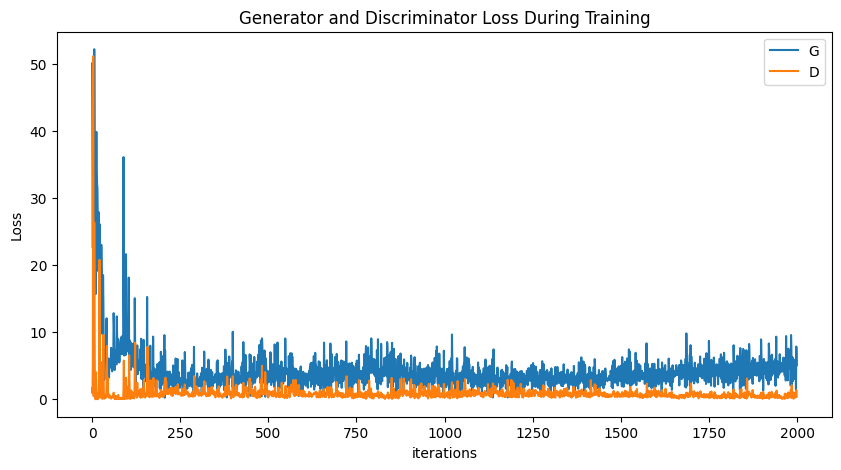

In [23]:
loss_plot(G_losses=G_losses, D_losses=D_losses, out='')

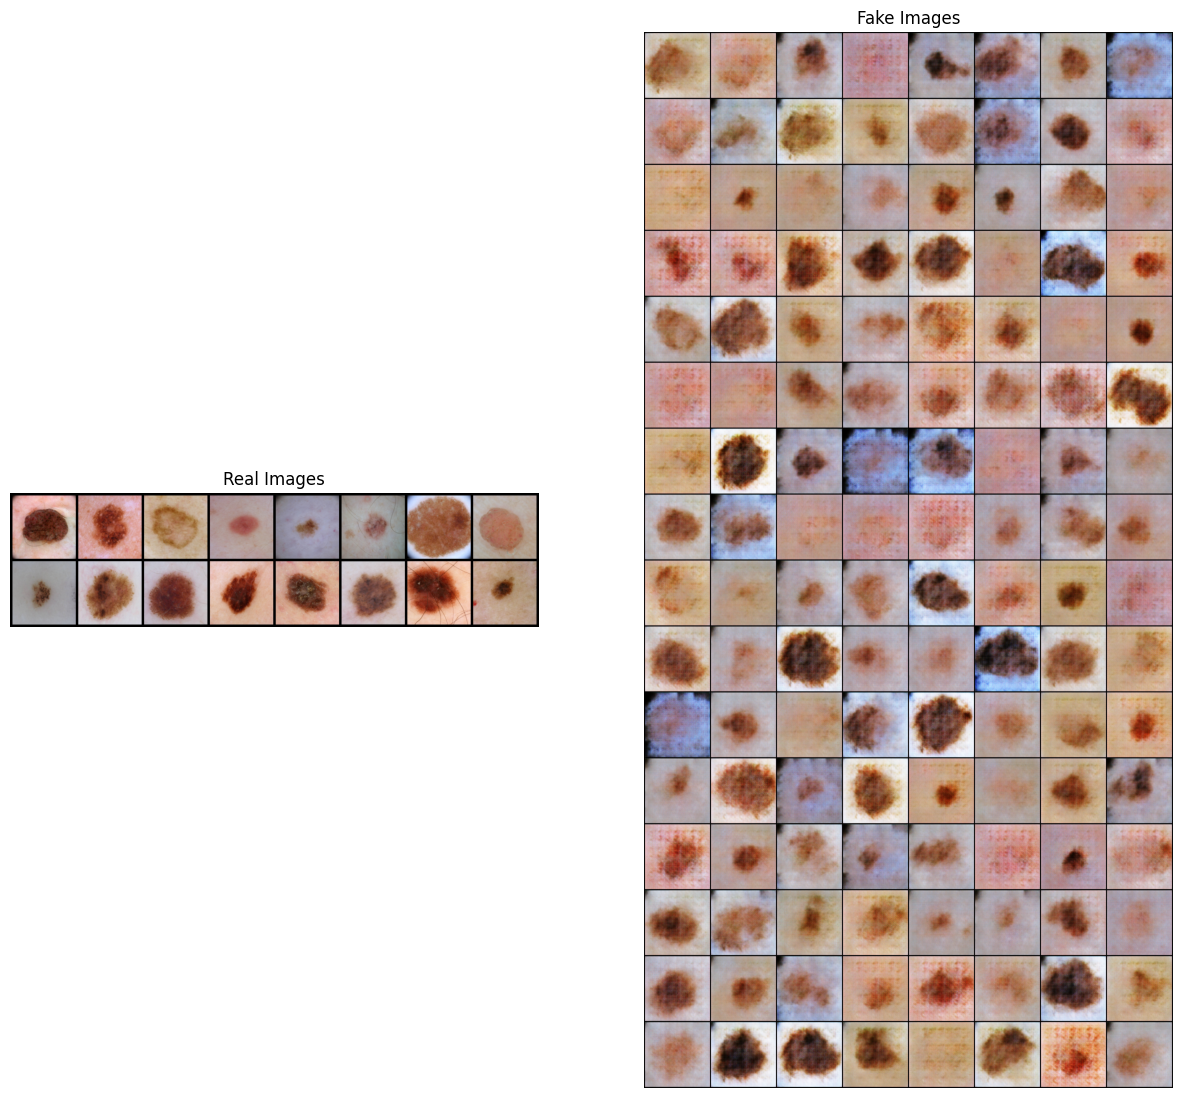

In [24]:
image_grid(dataloader=dataloader, img_list=img_list,
                   device=device, out='')

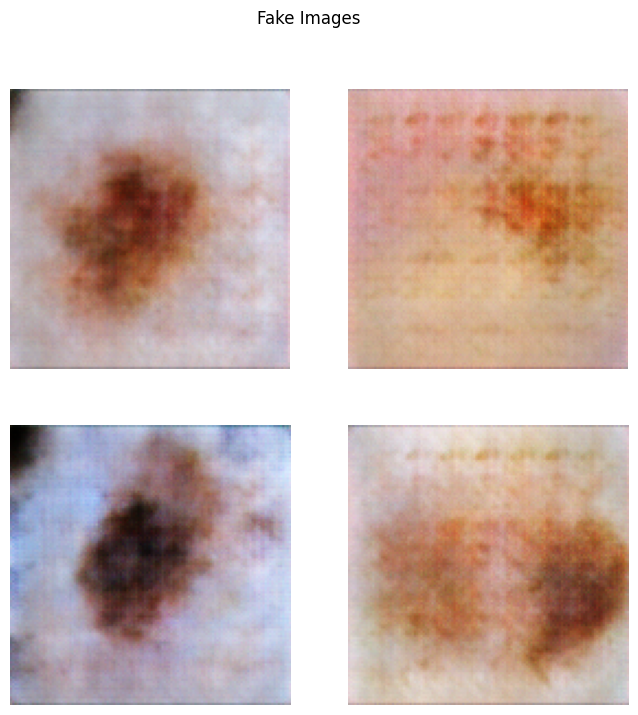

In [25]:
noise = torch.randn(4, 100, 1, 1, device=device)
tensor = netG(noise).detach().cpu()
tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
fig.suptitle('Fake Images')

for i, ax in enumerate(axes.flatten()):
    image = tensor[i].numpy().transpose(1, 2, 0)
    ax.imshow(image)
    ax.axis('off')

plt.show()

In [26]:
dataloader2 = dataLoader(
            path='/kaggle/input/adenocarcinoma-cancer', 
            image_size=imageSize,
            batch_size=batchSize,
            workers=workersNum)

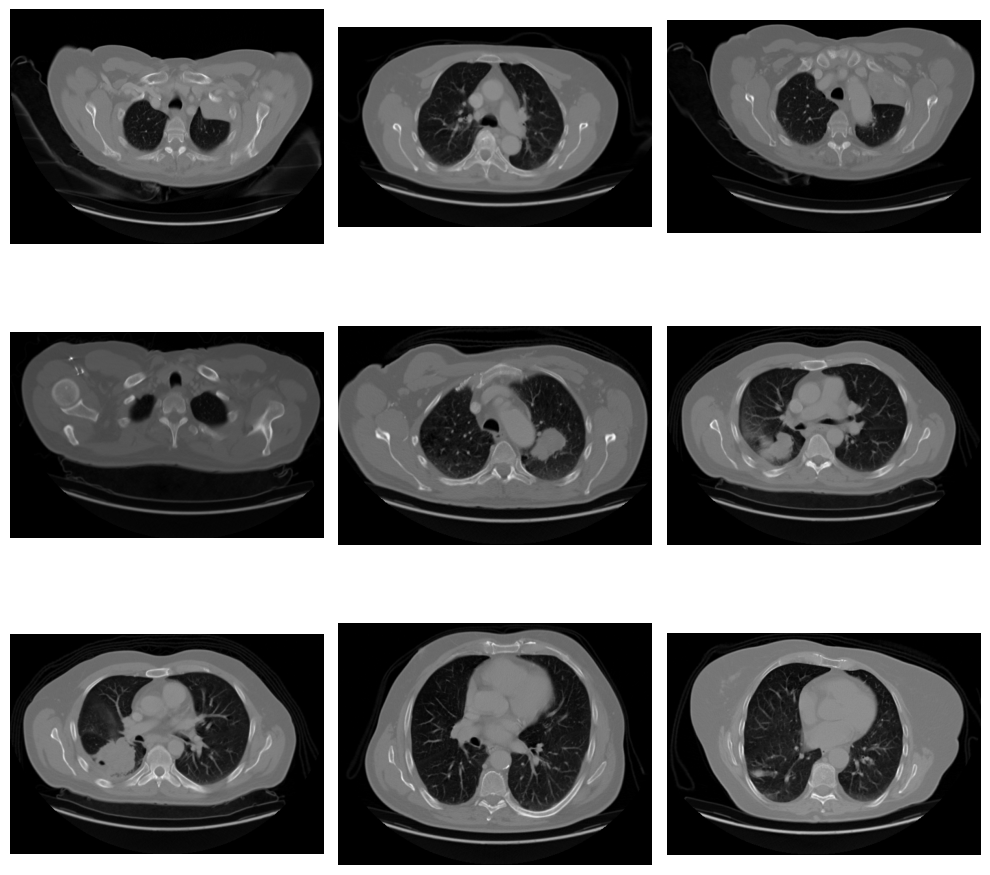

In [27]:
import matplotlib.pyplot as plt

directory = '/kaggle/input/adenocarcinoma-cancer/adenocarcinoma'
imageFiles = [file for file in os.listdir(directory) if file.endswith('.jpg') or file.endswith('.png')]
numImages = min(len(imageFiles), 9)
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i in range(numImages):
    img = plt.imread(os.path.join(directory, imageFiles[i]))
    axes[i // 3, i % 3].imshow(img)
    axes[i // 3, i % 3].axis('off')
plt.tight_layout()
plt.show()

In [28]:
os.makedirs('/kaggle/working/trainImgs2',exist_ok=True)
G_losses, D_losses, img_list, img_list_only = training_loop(num_epochs=200, dataloader=dataloader2,
                                                            netG=netG, netD=netD, device=device, loss=loss, latVec=latentVector,
                                                            optimizerG=optimizerG, optimizerD=optimizerD, fixed_noise=fixed_noise, out='/kaggle/working/trainImgs2')

Starting Training Loop...
[0/200]	Loss_D: 3.4217	Loss_G: 3.1393
[1/200]	Loss_D: 0.4180	Loss_G: 7.5202
[2/200]	Loss_D: 0.4064	Loss_G: 9.2555
[3/200]	Loss_D: 0.4529	Loss_G: 6.8500
[4/200]	Loss_D: 0.6783	Loss_G: 6.8669
[5/200]	Loss_D: 0.0871	Loss_G: 9.2531
[6/200]	Loss_D: 0.1415	Loss_G: 9.9776
[7/200]	Loss_D: 2.1853	Loss_G: 6.0199
[8/200]	Loss_D: 1.0652	Loss_G: 16.7512
[9/200]	Loss_D: 0.1438	Loss_G: 4.6047
[10/200]	Loss_D: 0.2164	Loss_G: 12.6283
[11/200]	Loss_D: 0.4313	Loss_G: 14.5772
[12/200]	Loss_D: 0.0118	Loss_G: 6.3959
[13/200]	Loss_D: 0.0301	Loss_G: 7.6995
[14/200]	Loss_D: 1.3733	Loss_G: 7.9665
[15/200]	Loss_D: 0.0166	Loss_G: 9.3265
[16/200]	Loss_D: 2.3283	Loss_G: 8.6182
[17/200]	Loss_D: 0.5771	Loss_G: 5.4463
[18/200]	Loss_D: 0.1119	Loss_G: 11.0069
[19/200]	Loss_D: 0.7807	Loss_G: 10.3943
[20/200]	Loss_D: 1.0867	Loss_G: 17.2988
[21/200]	Loss_D: 0.0537	Loss_G: 4.0048
[22/200]	Loss_D: 1.1434	Loss_G: 24.6702
[23/200]	Loss_D: 2.8067	Loss_G: 14.1008
[24/200]	Loss_D: 3.6453	Loss_G: 19.7989


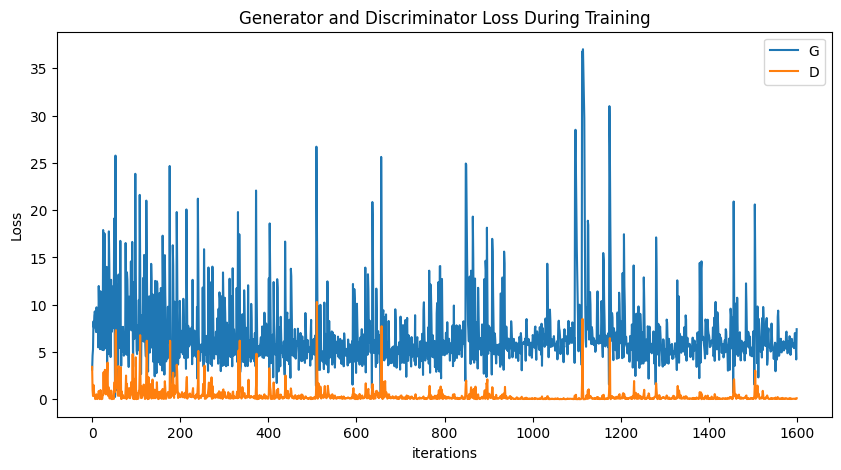

In [29]:
loss_plot(G_losses=G_losses, D_losses=D_losses, out='')

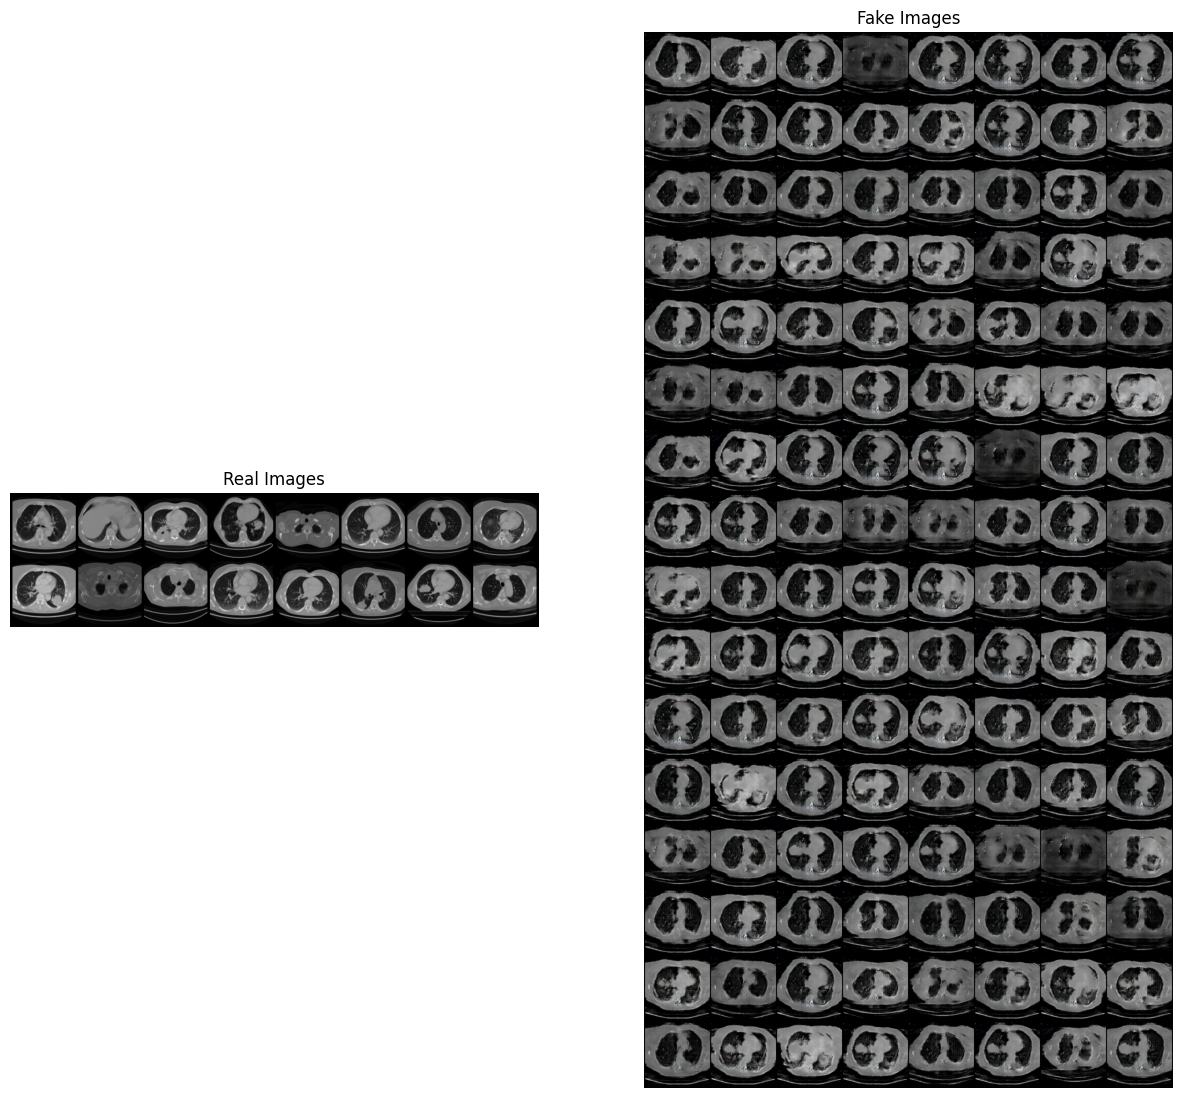

In [30]:
image_grid(dataloader=dataloader2, img_list=img_list,
                   device=device, out='')

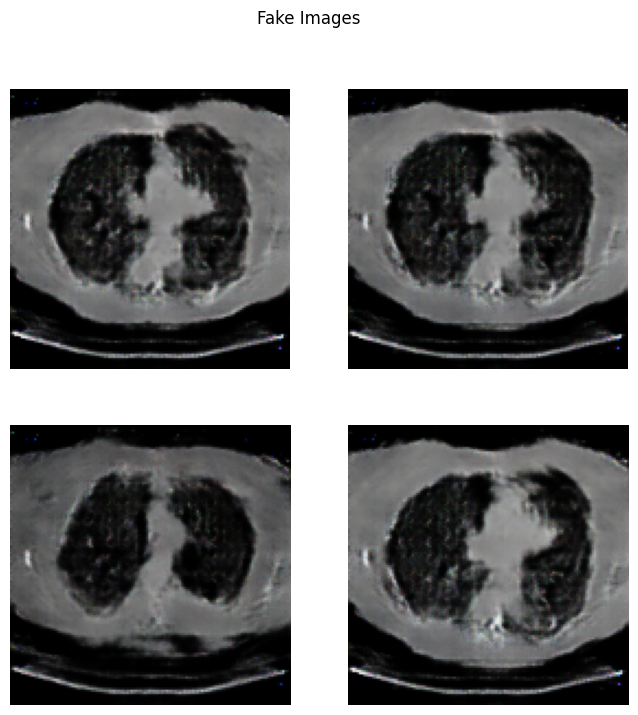

In [31]:
noise = torch.randn(4, 100, 1, 1, device=device)
tensor = netG(noise).detach().cpu()
tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
fig.suptitle('Fake Images')

for i, ax in enumerate(axes.flatten()):
    image = tensor[i].numpy().transpose(1, 2, 0)
    ax.imshow(image)
    ax.axis('off')

plt.show()